In [145]:
from __future__ import print_function
# import jax
# import jax.numpy as np
import random
import numpy as onp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches

### Create mixture of gaussian data

In [146]:
def create_mixture_of_gaussian(batch_size, mean_var):
    nb_samples = batch_size #// len(mean_var) 
    data = [onp.random.multivariate_normal(params[0], params[1], int(nb_samples*params[2])) for params in mean_var]
    #label = [onp.zeros(data[0].shape[0]), onp.ones(data[1].shape[0])]
    return onp.vstack(data)#, onp.vstack(label).reshape(-1,)

def plot_dataset(ax, data, size=4, cmap="Reds", label="Ground truth"):
    ax.set_aspect('equal')
    ax.set_ylim((-size, size))
    ax.set_xlim((-size, size))
    ax.tick_params(labelsize=10)
    sns.kdeplot(
        data[:, 0],
        data[:, 1],
        cmap=cmap,
        ax=ax,
        )

In [149]:
p = 1.0
batch_size=64
mean_std = [[[0,0],[[1,0],[0,1]], p], [[2,2],[[0.5,0],[0,0.5]],1-p]]
data_indices = [create_mixture_of_gaussian(batch_size, mean_std) for _ in range(2000)]
data = onp.vstack([d for d in data_indices])
#label = np.vstack([d[1] for d in data_indices])
#data = 2*((data - np.min(data))/(np.max(data) - np.min(data))) - 1
#data = (data - onp.min(data))/(onp.max(data) - onp.min(data))

### MLE to estimate parameters of a Gaussian

Maximum Likelihood Estimation to estimate parameters of a gaussian distribution:
$$\mu_{ML} = \frac{1}{N} \sum_{n=1}^{N} x_{n}$$
$$\Sigma_{ML} = \frac{1}{N} \sum_{n=1}^{N} (x_{n} - \mu)(x_{n} - \mu)^T$$

KeyboardInterrupt: 

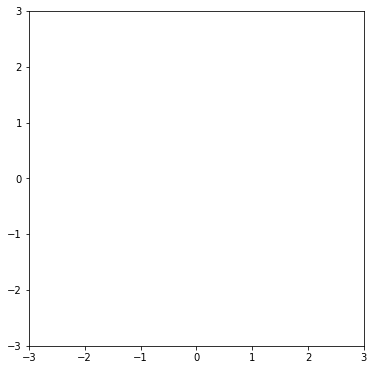

In [148]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=3)

# Estimate the mean and covariance from data
# mu_estimate = onp.mean(data, axis=0)
# covar_estimate = onp.matmul(onp.transpose(data - mu_estimate),(data-mu_estimate)) / data.shape[0]
# mean_var_estimate = [[mu_estimate, covar_estimate, 1.0]]

# # Generate data from estimated mean and variance
# gen_data_indices = [create_mixture_of_gaussian(batch_size, mean_var_estimate) for _ in range(100)]
# generated_data = onp.vstack([d for d in gen_data_indices])
#plot_dataset(ax, generated_data, size=1.2, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

### Lets create a simple model

In [ ]:
eps = 1e-10
def BCE(output, y):
    return np.mean(-y * np.log(output + eps) - (1-y)*np.log(1-output + eps), axis=0)[0]

# def BCE(output, y):
#     return - np.mean(y * np.exp(output + eps) + (1-y)*(1+output + eps), axis=0)[0]

# def BCE(output, y):
#     return np.mean(-y * np.exp(-output) - (1-y)*(1+np.log(-output)), axis=0)[0]


def gen_loss(generator_params, discriminator_params, noise, y):
    gen_out = generator_net_apply(generator_params, noise)
    prediction = discriminator_net_apply(discriminator_params, gen_out)
    loss_value = BCE(prediction, y)
    return loss_value
    
def disc_loss(p, x, y):
    prediction = discriminator_net_apply(p, x)
    loss_value = BCE(prediction, y)
    return loss_value

@jit
def generator_step(i, disc_opt_state, gen_opt_state, noise, y):
    generator_params = gen_get_params(gen_opt_state)
    discriminator_params = disc_get_params(disc_opt_state)
    g = grad(gen_loss)(generator_params, discriminator_params, noise, y)
    return gen_opt_update(i, g, gen_opt_state)

@jit
def discriminator_step(i, opt_state, x, y):
    p = disc_get_params(opt_state)
    g = grad(disc_loss)(p, x, y)
    return disc_opt_update(i, g, opt_state)

def sample_generator(gen_opt_state, input_data):
    gen_param = gen_get_params(gen_opt_state)
    return generator_net_apply(gen_param, input_data)

def train_discriminator(i, disc_opt_state, real_data, fake_data):
    disc_opt_state = discriminator_step(i, disc_opt_state, real_data, np.ones((real_data.shape[0],1), dtype=np.float32))    
    disc_opt_state = discriminator_step(i, disc_opt_state, fake_data, np.zeros((real_data.shape[0],1), dtype=np.float32))   
    return disc_opt_state
    
def train_generator(i, disc_opt_state, gen_opt_state, noise):    
    gen_opt_state = generator_step(i, disc_opt_state, gen_opt_state, noise, np.ones((noise.shape[0],1), dtype=np.float32))
    return gen_opt_state

In [ ]:
from jax.experimental import stax
from jax import random
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Sigmoid, Tanh, Flatten, LogSoftmax, Softplus, LeakyRelu # neural network layers
from jax.experimental import optimizers
from jax import jit, grad

generator_net_init, generator_net_apply = stax.serial(
        Dense(5), Tanh,
        Dense(3), Tanh,
        Dense(2), Relu
)

discriminator_net_init, discriminator_net_apply = stax.serial(
        Dense(5), Tanh,
        Dense(3), Tanh,
        Dense(1), Sigmoid
)
latent_size = 5
key = random.PRNGKey(onp.random.randint(0,999999))
key, subkey = random.split(key)
generator_in_shape = (-1, latent_size)
generator_out_shape, generator_net_params = generator_net_init(subkey, generator_in_shape)

key, subkey = random.split(key)
discriminator_in_shape = (-1, 2)
discriminator_out_shape, discriminator_net_params = discriminator_net_init(subkey, discriminator_in_shape)

In [ ]:
# Initialize adam optimizer for generator and discriminator
gen_opt_init, gen_opt_update, gen_get_params = optimizers.sgd(step_size=1e-2)
gen_opt_state = gen_opt_init(generator_net_params)

disc_opt_init, disc_opt_update, disc_get_params = optimizers.sgd(step_size=1e-2)
disc_opt_state = disc_opt_init(discriminator_net_params)

In [ ]:
noise = onp.random.uniform(size=(1000, latent_size))

generated_data = sample_generator(gen_opt_state, noise)
plt.plot(generated_data[:,0], generated_data[:,1],'o')
prob = discriminator_net_apply(disc_get_params(disc_opt_state), generated_data)
print(prob[:5])

In [ ]:
batch_size = 32
for i in range(30000):
    real_data = create_mixture_of_gaussian(batch_size, mean_std)
    #real_data = data[onp.random.choice(data.shape[0], size=batch_size)]    
    noise = onp.random.uniform(size=(batch_size, latent_size))
    fake_data = sample_generator(gen_opt_state, noise)
    #print(fake_data[:2,])
    # Train discriminator
    disc_opt_state = train_discriminator(i, disc_opt_state, real_data, fake_data)    
    # Train generator
#     for j in range(10):
    gen_opt_state = train_generator(i, disc_opt_state, gen_opt_state, noise)    
    if i % 1000 == 0:
        print(i)
    

In [ ]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=1.2)

noise = onp.random.uniform(size=(1000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)

print(generated_data)
plot_dataset(ax, generated_data, size=1.2, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

In [ ]:
# # Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
# plot_dataset(ax, data, size=1)

noise = onp.random.normal(size=(4000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)
#print(generated_data)
plot_dataset(ax, generated_data, size=2, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

# Try PyTorch

In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

In [151]:
def get_real_sampler():
    return lambda m, n : create_mixture_of_gaussian(m, n)#.requires_grad_()
#     return lambda m, n: dist.sample( (m, n) ).requires_grad_()

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # Uniform-dist data into generator, _NOT_ Gaussian

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
actual_data = get_real_sampler()
#actual_data = torch.from_numpy(data).cuda()
noise_data = get_noise_sampler()

cuda:0


In [153]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
#         self.map1 = nn.Linear(input_size, hidden_size)
#         self.map2 = nn.Linear(hidden_size, hidden_size)
#         self.map3 = nn.Linear(hidden_size, output_size)
#         self.xfer = torch.nn.Sigmoid()
        self.map1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.map1(x)
#         x = self.xfer( self.map1(x) )
#         x = self.xfer( self.map2(x) )
#         return self.xfer( self.map3( x ) )

In [154]:
class  Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        return torch.sigmoid( self.map3(x) )

In [155]:
latent_size = 10
hidden_size = 32
output_size = 2

d_minibatch_size = 64
g_minibatch_size = 64


G = Generator(input_size=latent_size, hidden_size=hidden_size, output_size=output_size)
D = Discriminator(input_size=output_size, hidden_size=hidden_size, output_size=1)


In [156]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=5e-2) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=1e-2) #, betas=optim_betas)
eps = 1e-10
# def bceLoss(output, target):
#     return torch.mean(-target * torch.log(output + eps) - (1 - target) * torch.log(1-output+eps), axis=0)
#     #return onp.mean(-target * onp.log(output + eps) - (1-target)*onp.log(1-output + eps), axis=0)[0]

def bceLoss(output, target):
    return torch.mean(target * torch.exp(output + eps) - (1 - target) * (1+output), axis=0)
    #     return - np.mean(y * np.exp(output + eps) + (1-y)*(1+output + eps), axis=0)[0]



In [157]:
def train_D_on_actual() :
    real_data = torch.Tensor(actual_data( d_minibatch_size, mean_std ))
    decision = D( real_data )
    error = bceLoss( decision, torch.ones( d_minibatch_size, 1 ))  # ones = true
    error.backward()
    
def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, latent_size )
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = bceLoss( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()
    
    
def train_G():
    noise = noise_data( g_minibatch_size, latent_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = bceLoss( fake_decision, torch.ones( g_minibatch_size, 1 ) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

In [158]:
losses = []
num_epochs = 10000
for epoch in range(num_epochs):
    D.zero_grad()

    for _ in range(5):
        train_D_on_actual()    
        train_D_on_generated()
        d_optimizer.step()
    
    G.zero_grad()
    for _ in range(5):
        loss,generated = train_G()
        g_optimizer.step()
    
    losses.append( loss )
    #print(epoch)
#     if( epoch % print_interval) == (print_interval-1) :
#         print( "Epoch %6d. Loss %5.3f" % ( epoch+1, loss ) )
        
print( "Training complete" )

Training complete


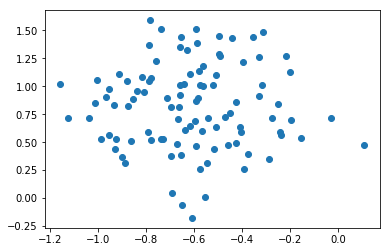

In [159]:
noise = noise_data(100, latent_size )
fake_data = G( noise ).detach().numpy()
plt.plot(fake_data[:,0], fake_data[:,1],"o")

[[-0.5791855   1.1344304 ]
 [-0.57476676  0.2600997 ]
 [-1.1599485   1.0214663 ]
 [-0.2427103   0.592294  ]
 [-0.75959444  1.2234296 ]
 [-0.8798083   1.0511954 ]
 [-0.42434943  0.8593459 ]
 [-0.61838603  1.1119131 ]
 [-0.4502729   0.7599018 ]
 [-0.65725374  1.4389497 ]
 [-0.5100031   1.1041843 ]
 [-0.15287952  0.5346185 ]
 [-0.58766127  1.387913  ]
 [-1.0132821   0.85486734]
 [-0.4038451   0.59064543]
 [-0.6951643   0.81762415]
 [-0.44108814  1.4343036 ]
 [-0.5474881   0.31607974]
 [-0.7317387   0.530227  ]
 [-0.90201324  0.37010443]
 [-0.5915402   0.46702445]
 [-0.5176102   0.4420366 ]
 [-0.66148144  0.92454296]
 [-0.3930136   0.2589459 ]
 [-0.71537685  0.89760345]
 [-0.45892578  0.47783676]
 [-1.0380859   0.719265  ]
 [-0.8650686   0.51039815]
 [-0.47267246  0.72777337]
 [-0.27795124  0.7178149 ]
 [-0.6092766  -0.1783193 ]
 [-0.95615125  0.972716  ]
 [-0.3173696   1.0151173 ]
 [-0.19524604  0.70051354]
 [-0.66553175  0.8116169 ]
 [-0.8091781   0.9460531 ]
 [-0.7904357   1.0456231 ]
 

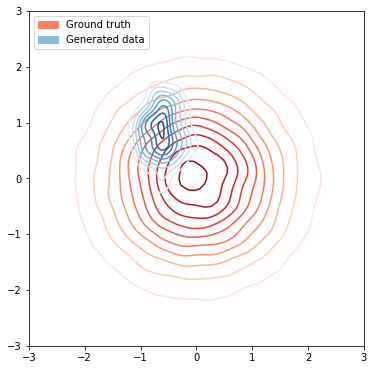

In [160]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=3)

noise = onp.random.uniform(size=(1000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = fake_data#sample_generator(gen_opt_state, noise)

print(generated_data)
plot_dataset(ax, generated_data, size=3, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")